In [1]:
import numpy as np
import pandas as pd

In [2]:
def cargar(ruta):
    input_file = ruta
    df = pd.read_csv(input_file, header=0)
    return df[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]]

In [3]:
# Cargar datos de conduccion de Carlos
ruta = "Final/datos_movimiento.csv"
datos_total = cargar(ruta) # 37 segundos de diferencia zony + 37 seg, xiaomi +0

In [4]:
# Anomalias
anomaly = np.zeros(len(datos_total))

anomaly[22865:22892]=1 # zig zag
anomaly[22903:22926]= 0 # tierra
anomaly[22966:22990]=1 # zig zag
anomaly[23015:23027]=1 # zig zag
anomaly[23158:23183]= 0 # tierra
anomaly[23212:23236]=1 # zig zag 
anomaly[23256:23274]=1 # zig zag

anomaly[23556:23562]=1 # giros a alta velocidad
anomaly[23590:23596]=1
anomaly[23606:23612]=1
anomaly[23615:23621]=1
anomaly[23760:23766]=1
anomaly[23774:23779]=1
anomaly[24794:24798]=1

anomaly[23933:24939]=0 # anomalias raras
anomaly[25076:25086]=0

anomaly[25502:25506]=1 # frenos en seco
anomaly[25575:25579]=1
anomaly[25623:25627]=1
anomaly[25710:25714]=1
anomaly[25838:25842]=1
anomaly[25871:25875]=1

datos_total['anomaly'] = anomaly

In [30]:
datos_total[23212:].head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,anomaly
23212,4.798996,0.255478,6.945023,0.039642,0.007202,0.053223,1.0
23213,5.240753,0.271469,7.980225,0.001465,-0.008545,0.012909,1.0
23214,3.782837,2.956512,9.081879,0.141922,0.033630,0.275391,1.0
23215,3.934250,-1.654572,8.836624,-0.072769,0.014938,0.067108,1.0
23216,4.147018,-2.078308,8.994507,-0.140060,0.008530,-0.339828,1.0


In [14]:
import os
import tensorflow as tf
from keras import backend as K
import random as rn
rand_seed = 321
os.environ['PYTHONHASHSEED'] = '0'

#random seed for NP genreator of ranodm numbers
np.random.seed(rand_seed)

#random seed generator for Python
rn.seed(rand_seed)

#random seed for tensorflow
tf.random.set_seed(rand_seed)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

AttributeError: module 'tensorflow' has no attribute 'Session'

In [6]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import matplotlib.transforms as mtransforms

In [7]:
def dibujar_sensores(df):
    fig, ax = plt.subplots()
    indices = list(range(0,len(df)))
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    ax.plot(indices, df['acc_x'], 'r', label='ACC-X')
    ax.plot(indices, df['acc_y'], 'b', label='ACC-Y')
    ax.plot(indices, df['acc_z'], 'g', label='ACC-Z')
    ax.plot(indices, df['gyr_x'], 'm', label='GYR-X')
    ax.plot(indices, df['gyr_y'], 'c', label='GYR-Y')
    ax.plot(indices, df['gyr_z'], 'k', label='GYR-Z')

    ax.set(ylabel='Valores sensores', xlabel='Tiempo (Segundos)', title='Datos capturados - Horizontal')
    ax.legend()
    plt.xlabel('Datos')
    plt.savefig('horizontal.png')
    plt.show() 

In [8]:
data3 = pd.concat([datos_total[:17224], datos_total[17290:17661], datos_total[28400:]])[:30000] 

<IPython.core.display.Javascript object>


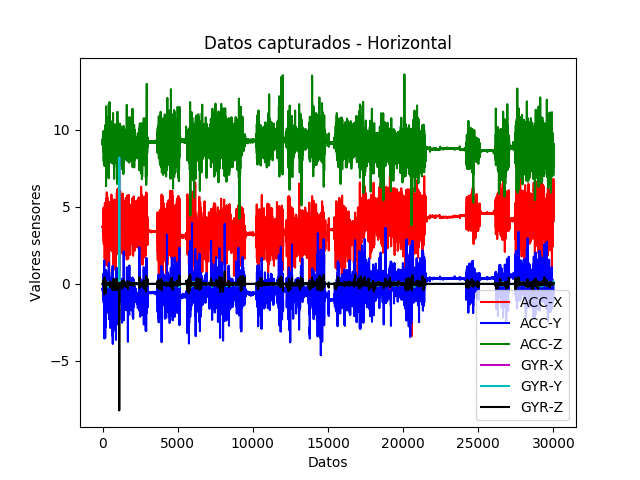

In [9]:
dibujar_sensores(data3)

In [10]:
def delete_outliers(data_column, limit):
    elements = np.array(data_column)
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    final_list = [x for x in elements if (x > mean - limit * sd)]
    final_list = [x for x in final_list if (x < mean + limit * sd)]
    return np.array(final_list)

In [11]:
from sklearn import preprocessing

i = 3
val_1 = delete_outliers(data3["acc_x"], i)
val_2 = delete_outliers(data3["acc_y"], i)
val_3 = delete_outliers(data3["acc_z"], i)
val_4 = delete_outliers(data3["gyr_x"], i)
val_5 = delete_outliers(data3["gyr_y"], i)
val_6 = delete_outliers(data3["gyr_z"], i)

max_val = min([len(val_1),len(val_2),len(val_3),len(val_4),len(val_5),len(val_6)])

a = np.concatenate((val_1[:max_val].reshape(max_val,1), val_2[:max_val].reshape(max_val,1), val_3[:max_val].reshape(max_val,1), val_4[:max_val].reshape(max_val,1), val_5[:max_val].reshape(max_val,1), val_6[:max_val].reshape(max_val,1)), axis=1)

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from keras.layers import Input, Dense,  Flatten, Reshape
from keras.models import Model

Using TensorFlow backend.


In [13]:
scaler = MinMaxScaler()
scaler.fit(a)
x = scaler.transform(data3[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]])
total = scaler.transform(datos_total[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]][:-20])

In [14]:
x = pd.DataFrame({'acc_x': x[:,0], 'acc_y': x[:,1], 'acc_z': x[:,2], 'gyr_x': x[:,3], 'gyr_y': x[:,4], 'gyr_z': x[:,5]})

In [15]:
y = x.loc[((x.acc_x <= 1) & (x.acc_x >= 0)) &((x.acc_y <= 1) & (x.acc_y >=0))& ((x.acc_z <= 1) & (x.acc_z >=0)) &((x.gyr_x <= 1) & (x.gyr_x >=0))&((x.gyr_y <= 1) & (x.gyr_y >=0)) &((x.gyr_z <= 1) & (x.gyr_z >=0)) ]
y.shape

(28719, 6)

[0.51035188 0.20696465 0.13414971 0.07489895 0.05038002 0.02325478]


<IPython.core.display.Javascript object>


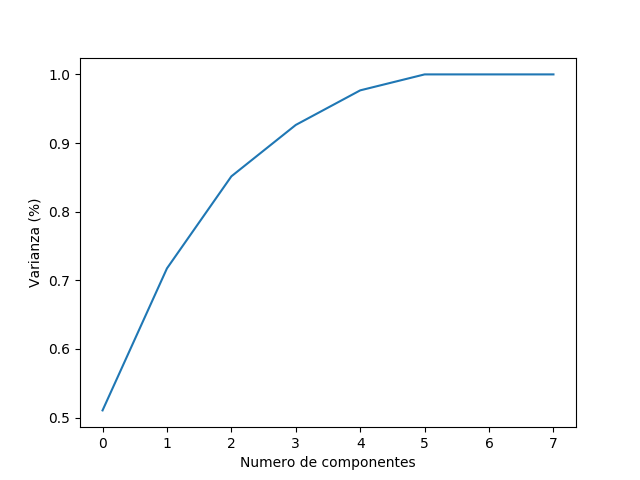

In [16]:

from sklearn.decomposition import PCA
#Fitting the PCA algorithm with our Data
pca = PCA().fit(y)

print(pca.explained_variance_ratio_)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(np. concatenate((pca.explained_variance_ratio_, [0,0]))))
plt.xlabel('Numero de componentes')
plt.ylabel('Varianza (%)') #for each component
plt.savefig("pca.png")
plt.show()

In [19]:
pca3 = PCA(n_components=3)
pca3.fit(y)
principalComponents3 = pca3.transform(x)
principalComponentsTotal3 = pca3.transform(total)

In [20]:
def generate_seq_data1(d, l):
    inp = []
    for i in range(len(d)):
        if len(d)>i+l-1:
            inp.append(d[i:i+l])
    return np.asarray(inp)

In [21]:

i_e3 = generate_seq_data1(principalComponents3, 3)

In [23]:
import tensorflow as tf
import random as rn

rand_seed = 321

np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)
lrelu = lambda x:tf.keras.activations.relu(x, alpha=0.1)

In [24]:
np.random.shuffle(i_e3)

train3, dev3, test3 = np.split(i_e3, [int(.70*len(i_e3)), int(.85*len(i_e3))])

In [29]:
print(train3[0])

[[-0.23741299 -0.46793018 -0.10110629]
 [-0.38359244 -0.61445477 -0.20721483]
 [-0.42607211 -0.51635899 -0.10877916]]


In [32]:
inputs = Input(shape=(3,3))
x = Flatten()(inputs) #49152 #3072
#x = BatchNormalization()(x)
x = Dense(8, activation='elu')(x)
encoded = Dense(5, activation='elu')(x)
encoder = Model(inputs, encoded)
encoder.summary()

decoder_input= Input(shape=(5,))
#x = BatchNormalization()(x)
x = Dense(8, activation='elu')(decoder_input)
outputs = Dense(9, activation='tanh')(x)
#outputs = BatchNormalization()(outputs)
decoded = Reshape((3,3))(outputs)

decoder = Model(decoder_input, decoded)
decoder.summary()

auto_input = Input(shape=(3,3))
encoded = encoder(auto_input)
decoded = decoder(encoded)

model_nn3 = Model(auto_input, decoded)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 3)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5)                 0         
____________________________________________

In [33]:
model_nn3.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model_nn3.fit(train3, train3,
                epochs=50,
                batch_size=64,
                validation_data=(dev3, dev3),
                verbose=1)

Train on 20998 samples, validate on 4500 samples
Epoch 1/50
20998/20998 [==============================] - 1s 40us/step - loss: 0.0224 - accuracy: 0.6424 - val_loss: 0.0093 - val_accuracy: 0.8229
Epoch 2/50
20998/20998 [==============================] - 1s 34us/step - loss: 0.0082 - accuracy: 0.8375 - val_loss: 0.0073 - val_accuracy: 0.8480
Epoch 3/50
20998/20998 [==============================] - 1s 35us/step - loss: 0.0068 - accuracy: 0.8573 - val_loss: 0.0063 - val_accuracy: 0.8603
Epoch 4/50
20998/20998 [==============================] - 1s 38us/step - loss: 0.0059 - accuracy: 0.8673 - val_loss: 0.0053 - val_accuracy: 0.8672
Epoch 5/50
20998/20998 [==============================] - 1s 39us/step - loss: 0.0050 - accuracy: 0.8700 - val_loss: 0.0048 - val_accuracy: 0.8687
Epoch 6/50
20998/20998 [==============================] - 1s 42us/step - loss: 0.0048 - accuracy: 0.8722 - val_loss: 0.0047 - val_accuracy: 0.8699
Epoch 7/50
20998/20998 [==============================] - 1s 33us/ste

In [34]:
model_nn3.evaluate(test3, test3, verbose=1)

4500/4500 [==============================] - 0s 31us/step


[0.003949672318994999, 0.899481475353241]

In [35]:
def isolationForestModel(diff, cont= 0.1):
    model =  IsolationForest(contamination=cont)
    model.fit(diff)
    return model

In [36]:
# result_nn3 = model_nn3.predict(i_e_total3)
result_nn3 = model_nn3.predict(i_e3)

# diff_nn3 = result_nn3 - i_e_total3
diff_nn3 = result_nn3 - i_e3

In [37]:
#isolation_model = isolationForestModel(predicted.reshape(len(predicted), 5), 0.0075)
isolation_model = isolationForestModel(diff_nn3.reshape(len(diff_nn3), 9), 0.00750)

In [38]:
i_e_total3 = generate_seq_data1(principalComponentsTotal3, 3)

In [39]:
result_nn3 = model_nn3.predict(i_e_total3)
#result_nn3 = model_nn3.predict(i_e3)

diff_nn3 = result_nn3 - i_e_total3
#diff_nn3 = result_nn3 - i_e3

# mse_nn3 = np.power(np.absolute(diff_nn3), 2).sum(axis=1).sum(axis=1)
mse_nn3 =  np.power(np.absolute(diff_nn3).sum(axis=1).sum(axis=1),2)

In [40]:
#error_df = pd.DataFrame({'anomaly': isolation_model.predict(predicted.reshape(len(predicted), 5)),
#                        'true_class': datos_total['anomaly'].as_matrix()[2:-20]})
error_df = pd.DataFrame({'anomaly': isolation_model.predict(diff_nn3.reshape(len(diff_nn3), 9)),
                        'true_class': datos_total['anomaly'].as_matrix()[2:-20]})

/home/lin777/Documents/ServidorTesis/DriverAppServer/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [41]:
error_df['anomaly1'] = error_df['anomaly'].replace({1:0, -1:1})

In [42]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import seaborn as sns

<IPython.core.display.Javascript object>


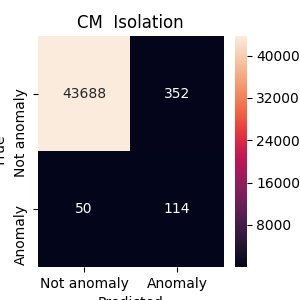

In [43]:
conf_matrix = confusion_matrix(error_df.true_class, error_df.anomaly1)
lbl_class = ["Not anomaly", "Anomaly"]

plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, xticklabels=lbl_class, yticklabels=lbl_class, annot=True, fmt="d");
plt.title("CM " + " Isolation")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [44]:
import matplotlib.transforms as mtransforms

def dibujar_anomalias1(df, nombre, anomalias):
    fig, ax = plt.subplots()
    indices = list(range(0,len(df)))
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    ax.plot(indices, df[:,0], 'r', label='ACC-X')
    ax.plot(indices, df[:,1], 'b', label='ACC-Y')
    ax.plot(indices, df[:,2], 'g', label='ACC-Z')
    
    ax.plot(indices, df[:,3], 'm', label='GYR-X')
    ax.plot(indices, df[:,4], 'c', label='GYR-Y')
    ax.plot(indices, df[:,5], 'k', label='GYR-Z')
    
    ax.fill_between(indices, 0, 1, where=error_df['true_class'].as_matrix() > 0.5,  facecolor='yellow', alpha=0.45, transform=trans)

    ax.fill_between(indices, 0, 1, where=anomalias > 0.5, facecolor='red', alpha=0.45, transform=trans)

    ax.set(ylabel='Valores sensores', xlabel='Tiempo (Segundos)', title=nombre)
    ax.legend()
    plt.grid()
    plt.show() 

/home/lin777/Documents/ServidorTesis/DriverAppServer/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/lin777/Documents/ServidorTesis/DriverAppServer/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


<IPython.core.display.Javascript object>


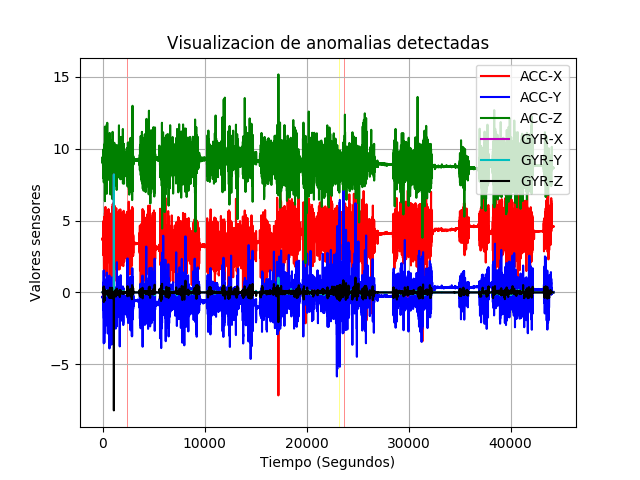

In [45]:
dibujar_anomalias1(datos_total[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].as_matrix()[2:-20].reshape(len(datos_total)-22, 6), 'Visualizacion de anomalias detectadas',error_df.anomaly1)

In [46]:
import json # will be needed for saving preprocessing details
import joblib # for saving algorithm and preprocessing objects

In [47]:
# save preprocessing objects and RF algorithm
joblib.dump(scaler, "./scaler.joblib", compress=True)
joblib.dump(pca3, "./pca.joblib", compress=True)
joblib.dump(model_nn3, "./model_nn3.joblib", compress=True)
joblib.dump(isolation_model, "./isolation_model.joblib", compress=True)

['./isolation_model.joblib']

In [8]:
import pandas as pd

df1 = pd.DataFrame("{'acc_x': {'0': 4.194016,'1': 4.206207,'2': 4.175949},'acc_y': {'0': -0.726532,'1': -0.716492,'2': -0.676086},'acc_z': {'0': 8.979568,'1': 8.832672,'2': 8.834686},'gyr_x':{'0': -0.000900,'1': -0.000732,'2': 0.000061},'gyr_y':{'0': -0.000748,'1': -0.000351,'2': 0.000183},'gyr_z': {'0': 0.000748,'1': 0.000870,'2': -0.000458}}", index=[0])

ValueError: DataFrame constructor not properly called!

{
    "acc_x": {
        "0": 4.194016,
        "1": 4.206207,
        "2": 4.175949
    },
    "acc_y": {
        "0": -0.726532,
        "1": -0.716492,
        "2": -0.676086
    },
    "acc_z": {
        "0": 8.979568,
        "1": 8.832672,
        "2": 8.834686
    },
    "gyr_x":{
        "0": -0.000900,
        "1": -0.000732,
        "2": 0.000061
    },
    "gyr_y":{
        "0": -0.000748,
        "1": -0.000351,
        "2": 0.000183
    },
    "gyr_z": {
        "0": 0.000748,
        "1": 0.000870,
        "2": -0.000458
    }
}

In [1]:
# file backend/server/apps/ml/income_classifier/random_forest.py
import joblib
import pandas as pd

class AnomalyDetector:

    __instance = None

    def __init__(self):
        path_to_artifacts = ""
        self.scaler =  joblib.load(path_to_artifacts + "scaler.joblib")
        self.pca = joblib.load(path_to_artifacts + "pca.joblib")
        self.model = joblib.load(path_to_artifacts + "model_nn3.joblib")
        self.if_model = joblib.load(path_to_artifacts + "isolation_model.joblib")

    def __new__(cls):
        if AnomalyDetector.__instance is None:
            AnomalyDetector.__instance = object.__new__(cls)
        return AnomalyDetector.__instance

    def preprocessing(self, input_data):
        # JSON to pandas DataFrame
        print(input_data)
        input_data = pd.DataFrame(input_data, index=[0])
        print(input_data)
        # fill missing values
        input_data = self.scaler.transform(input_data)
        input_data = self.pca.transform(input_data)

        return input_data

    def predict(self, input_data):
        diff = self.model.predict(input_data) - input_data
        return self.if_model.predict(diff)

    def postprocessing(self, input_data):
        label = "Normal"
        if input_data[1] < 1:
            label = "Anomaly"
        return {"probability": input_data[1], "label": label, "status": "OK"}

    def compute_prediction(self, input_data):
        try:
            input_data = self.preprocessing(input_data)
            prediction = self.predict(input_data)[0]  # only one sample
            prediction = self.postprocessing(prediction)
        except Exception as e:
            return {"status": "Error", "message": str(e)}

        return prediction

In [2]:
ad = AnomalyDetector()

Using TensorFlow backend.


In [4]:
ad.compute_prediction("{'acc_x': {'0': '4.194016', '1': '4.206207', '2': '4.175949'}, 'acc_y': {'0': '-0.726532', '1': '-0.716492', '2': '-0.676086'}, 'acc_z': {'0': '8.979568', '1': '8.832672', '2': '8.834686'}, 'gyr_x': {'0': '-0.0009', '1': '-0.000732', '2': '0.000061'}, 'gyr_y': {'0': '-0.000748', '1': '-0.000351', '2': '0.000183'}, 'gyr_z': {'0': '0.000748', '1': '0.00087', '2': '-0.000458'}}")

{'acc_x': {'0': '4.194016', '1': '4.206207', '2': '4.175949'}, 'acc_y': {'0': '-0.726532', '1': '-0.716492', '2': '-0.676086'}, 'acc_z': {'0': '8.979568', '1': '8.832672', '2': '8.834686'}, 'gyr_x': {'0': '-0.0009', '1': '-0.000732', '2': '0.000061'}, 'gyr_y': {'0': '-0.000748', '1': '-0.000351', '2': '0.000183'}, 'gyr_z': {'0': '0.000748', '1': '0.00087', '2': '-0.000458'}}


{'status': 'Error', 'message': 'DataFrame constructor not properly called!'}